# <b>Hands-on scRNAseq data analysis and visualization workshop</b>

### <b>Overview</b>

<i>Hint: you can right click on the "Watch on youtube" button and open the video in a new tab</i>


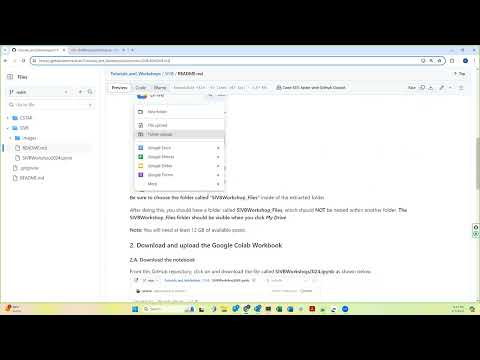

In [31]:
from IPython.display import YouTubeVideo
YouTubeVideo('J8U-I2G7XT0', width = 800, height = 400)

This notebook was developed as a simple hands-on walkthrough for the analysis
of single-cell RNA sequencing data. It is intended to be run using <b>[Google Colab](https://colab.research.google.com/)</b>, but can also be adopted for running on your own computing resources. The tutorial examines 3 key steps:

- <b>Setting up your analysis environment (section 1).</b>
- <b>Alignment of sequencing reads (section 2).</b>
- <b>Preliminary analysis with python (section 3).</b>

At the end of this tutorial we hope that you are able to receive raw sequencing
data from your own single-cell experiment and take it all the way to an initial UMAP visualization for clustering and cell annotation.

<b>In order for this notebook to run properly, be sure to allow it to connect
to the data folder on your google drive each time using the code block below.</b>

In [2]:
# Workshop only - accessing shared files
import os
from google.colab import drive

drive.mount('/content/drive')

directory = '/content/drive/My Drive/SIVBWorkshop_Files'
# List files in the directory
files = os.listdir(directory)

# Print the list of files
print("Files in the directory:")
for file in files:
    print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in the directory:
cellranger-8.0.0.tar.gz
refdata-gex-GRCm39-2024-A.tar.gz
5k_mouse_liver_CNIK_3pv3_fastqs
Bos_taurus.ARS-UCD1.3.111.gtf.gz
Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz
5k_mouse_liver_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz
5k_mouse_liver_CNIK_3pv3_web_summary.html


---

## __1. Setting up your analysis environment__<a id="experiment"></a>

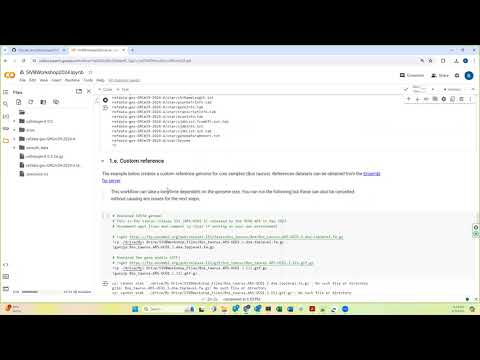

In [11]:
YouTubeVideo('e7alu1ybx8M', width = 800, height = 400)

This workshop will the the 10X Genomics CellRanger software as it is currently one of the most widely used platforms for single-cell sequencing. Tutorials for this and other workflows can be found at the following links:

[10X Genomics](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-in)

[Parse BioSciences](www.google.com)

[Curio BioSciences](www.curio.com)

> <b><i>USEFUL TIPS!</i></b> <ul> <b>(1)</b> In this interactive notebook you will see the character <b>"!"</b> used at the start of several lines of code. This is because we don't have direct access to the command line. If you were to run these analyses at your own institution it is best practice to gain access to a linux terminal such as an institution resource, Microsoft Azure, AWS, or other cloud providers. <br> <b>(2)</b> Keep an eye out for these indented notes. Here we will indicate if this step takes longer than 10 mins to run or if it is expected for fail on a free account.

### __1.a. Download and test CellRanger__

The following code describes how to download and install cellranger from the 10X Genomics server. The link (https://....) will change as 10X Genomics tries to prevent overload of their servers, so be sure to go to the vendor website directly for installation instructions.

*Note:* Always record your software versions!

In [ ]:
# All lines are commented as files are saved in a google drive for this workshop

# Download cellranger
# wget -O <link to cellranger-8.0.0.tar.gz>

# Unpack the cellranger software
# tar -xzvf cellranger-8.0.0.tar.gz

Typically you would want to add the cellranger directory to your $PATH (environment paths). We can't do this on Google Colab so we will use a workaround. However, to do this, run:<br>
`export PATH=/your/path/to/cellranger/cellranger.8.0.0:$PATH`

### __1.b. Run a sitecheck (check package)__
We will check that your system meets the requirements to run the cellranger pipeline. A description of each of the sections below can be found on the [10X Genomics tutorial](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-in). You will notice that our resources doesn't meet many of the criteria (e.g. fewer than required 8 CPU cores). This should be OK for our hands-on activities today but you will want to have access to more computational resources when processing your own data.

In [3]:
# Run this if working off of google colab code

# Copy the installation files from your google drive
!cp ./drive/My\ Drive/SIVBWorkshop_Files/cellranger-8.0.0.tar.gz .

# Unpack the installation files
!tar -xzf cellranger-8.0.0.tar.gz

# Check if the package is installed
!./cellranger-8.0.0/cellranger --help

cellranger cellranger-8.0.0

Process 10x Genomics Gene Expression, Feature Barcode, and Immune Profiling data

Usage: cellranger <COMMAND>

Commands:
  count           Count gene expression and/or feature barcode reads from a single sample and
                      GEM well
  multi           Analyze multiplexed data or combined gene expression/immune profiling/feature
                      barcode data
  multi-template  Output a multi config CSV template
  vdj             Assembles single-cell VDJ receptor sequences from 10x Immune Profiling
                      libraries
  aggr            Aggregate data from multiple Cell Ranger runs
  reanalyze       Re-run secondary analysis (dimensionality reduction, clustering, etc)
  mkvdjref        Prepare a reference for use with CellRanger VDJ
  mkfastq         Run Illumina demultiplexer on sample sheets that contain 10x-specific sample
                      index sets
  testrun         Execute the 'count' pipeline on a small test dataset
  m

You should see some instruction on how to use cellranger including a list of commands which will include count, multi, multi-template, etc... This means that the package is installed at the correct location.

Next we will run a simple check of the installation:

In [4]:
# This can be run directly in the command line
!./cellranger-8.0.0/cellranger sitecheck > sitecheck.txt

Sitecheck will output to a file ` > sitecheck.txt`. This can be used to ensure that your system had access to the necessary resources and for troubleshooting. We will not look at it more closely today but more information is available [here](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-in).

### __1.c. Perform a test run__

Run the following code. If the results states **Pipestance completed successfully**, then your cellranger should be working as expected.

> This can take more than 20 minutes and will fail using free google colab. Feel free to run it but it can be cancelled to go to the next step.

In [ ]:
# Perform test run
# Path is not needed if it was exported during installation
!./cellranger-8.0.0/cellranger testrun --id=check_install > check_install.txt &

### __1.d. Downloading a reference genome__

You will typically use a reference genome to align your sequencing reads to the genome of your model organism and get gene counts. Some vendors keep reference genomes in a format compatible with their software for a handful of the most common model organisms: Human, mouse, rat, drosophila, etc. See ["Build a custom reference for cell ranger (mkref)"](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-mr) for a tutorial on creating a reference genome for non-model organisms. Here we will work with the [mouse reference genome from 10X Genomics](https://www.10xgenomics.com/support/software/cell-ranger/downloads#reference-downloads).

__Note:__ Always record the version number, genome build, and any other information about the source to ensure that you can reproduce your results.

In [ ]:
# Run the following code in the command line
# Commented as the file is found in the google drive (see below)
#!wget "https://cf.10xgenomics.com/supp/cell-exp/refdata-gex-GRCm39-2024-A.tar.gz"

In [5]:
# Copy the reference genome for mouse from Google drive
!cp ./drive/My\ Drive/SIVBWorkshop_Files/refdata-gex-GRCm39-2024-A.tar.gz .

# Extract the files
!tar -xzvf refdata-gex-GRCm39-2024-A.tar.gz

^C
refdata-gex-GRCm39-2024-A/
refdata-gex-GRCm39-2024-A/genes/
refdata-gex-GRCm39-2024-A/genes/genes.gtf.gz
refdata-gex-GRCm39-2024-A/reference.json
refdata-gex-GRCm39-2024-A/star/
refdata-gex-GRCm39-2024-A/star/chrName.txt
refdata-gex-GRCm39-2024-A/star/chrStart.txt
refdata-gex-GRCm39-2024-A/star/chrLength.txt
refdata-gex-GRCm39-2024-A/star/chrNameLength.txt
refdata-gex-GRCm39-2024-A/star/exonGeTrInfo.tab
refdata-gex-GRCm39-2024-A/star/geneInfo.tab
refdata-gex-GRCm39-2024-A/star/transcriptInfo.tab
refdata-gex-GRCm39-2024-A/star/exonInfo.tab
refdata-gex-GRCm39-2024-A/star/sjdbList.fromGTF.out.tab
refdata-gex-GRCm39-2024-A/star/sjdbInfo.txt
refdata-gex-GRCm39-2024-A/star/sjdbList.out.tab
refdata-gex-GRCm39-2024-A/star/genomeParameters.txt
refdata-gex-GRCm39-2024-A/star/Genome
^C


### __1.e. Custom reference__

The example below creates a custom reference genome for cow samples (Bos taurus). References datasets can be obtained from the [Ensembl ftp server](https://useast.ensembl.org/info/data/ftp/index.html).

> This workflow can take a long time dependent on the genome size. You can run the following but these can also be cancelled without causing any issues for the next steps.

In [6]:
# Download FASTA genome
# This is Bos taurus release 111 (ARS-UCD1.3) released by the USDA ARS in May 2022
# Uncomment wget lines and comment cp lines if working on your own environment

# !wget https://ftp.ensembl.org/pub/release-111/fasta/bos_taurus/dna/Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz
!cp ./drive/My\ Drive/SIVBWorkshop_Files/Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz .
!gunzip Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz

# Download the gene models (GTF)
# !wget https://ftp.ensembl.org/pub/release-111/gtf/bos_taurus/Bos_taurus.ARS-UCD1.3.111.gtf.gz
!cp ./drive/My\ Drive/SIVBWorkshop_Files/Bos_taurus.ARS-UCD1.3.111.gtf.gz .
!gunzip Bos_taurus.ARS-UCD1.3.111.gtf.gz

#### __Filtering gene models__
We choose what type of transcripts we want to include when alignming the sequencing reads. These decisions should be driven by the biological considerations of your model.

In [7]:
# Keep only protein coding, lncRNA, and antisense genes
!./cellranger-8.0.0/cellranger mkgtf \
Bos_taurus.ARS-UCD1.3.111.gtf Bos_taurus.ARS-UCD1.3.111.filtered.gtf \
--attribute=gene_biotype:protein_coding
#--attribute=gene_biotype:lncRNA \
#--attribute=gene_biotype:antisense



Writing new genes GTF file (may take 10 minutes for a 1GB input GTF file)...
...done



#### __Building reference genome__
We then prepare the genome for the alignment software. <b>This step will likely fail given limited resources on this free analysis environment.</b>

In [8]:
# Run mkref (build reference genome)
!./cellranger-8.0.0/cellranger mkref \
--genome=Btau_10 \
--fasta=Bos_taurus.ARS-UCD1.3.dna.toplevel.fa \
--genes=Bos_taurus.ARS-UCD1.3.111.filtered.gtf \
--ref-version=1.0.0



Martian Runtime - v4.0.12
Serving UI at http://20a48b066573:36345?auth=ybr9W9nPDbkG_jCxZK4czNQ9V_NQRbJPiU0P2BZiiqU

Running preflight checks (please wait)...
2024-06-03 22:58:50 [runtime] (ready)           ID.mkref_Btau_10.MAKE_REFERENCE._MAKE_REFERENCE
2024-06-03 22:58:50 [runtime] (run:local)       ID.mkref_Btau_10.MAKE_REFERENCE._MAKE_REFERENCE.fork0.split
2024-06-03 22:58:50 [runtime] (split_complete)  ID.mkref_Btau_10.MAKE_REFERENCE._MAKE_REFERENCE
2024-06-03 22:58:50 [runtime] (run:local)       ID.mkref_Btau_10.MAKE_REFERENCE._MAKE_REFERENCE.fork0.join
2024-06-03 23:04:54 [runtime] (update)          ID.mkref_Btau_10.MAKE_REFERENCE._MAKE_REFERENCE.fork0 join_running
2024-06-03 23:05:25 [runtime] (failed)          ID.mkref_Btau_10.MAKE_REFERENCE._MAKE_REFERENCE

[error] mkref has failed: error building reference package
Failed to make genome index with STAR.  This can occasionally be caused by setting the argument `memgb` too low.
Error was from running command '/content/cellrang

---

## __2. Alignment of sequencing reads__<a id="align"></a>

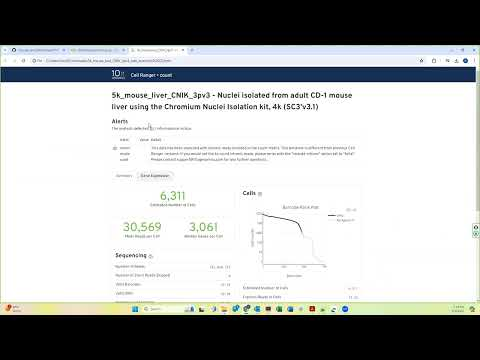

In [33]:
YouTubeVideo('fuISNSvpmIY', width = 800, height = 400)

Most sequencing cores will send you your sequencing results in a **FASTQ** format. In very rare instances you may beed to convert raw output BCL files according to vendor instructions.

### __2.a. What is a FASTQ file?__

FASTQ data will consist of four-line [repeating patterns](https://en.wikipedia.org/wiki/FASTQ_format):
@ERR059938.60 HS9_6783:8:2304:19291:186369#7/2
GTCTCCGGGGGCTGGGGGAACCAGGGGTTCCCACCAACCACCCTCACTCAGCCTTTTCCCTCCAGGCATCTCTGGGAAAGGACATGGGGCTGGTGCGGGG
+
7?CIGJB:D:-F7LA:GI9FDHBIJ7,GHGJBKHNI7IN,EML8IFIA7HN7J6,L6686LCJE?JKA6G7AK6GK5C6@6IK+++?5+=<;227*6054

in short, <br>
**line 1** is instrument information. <br>
**line 2** is the raw sequence letters. <br>
**line 3** can optionally provide additional sequence information. <br>
**line 4** encodes the quality values. <br>

In [12]:
# Downloading sample data from the 10X Genomics repository
# Commented as files are available on the shared drive
#!curl -O https://cf.10xgenomics.com/samples/cell-exp/7.0.0/5k_mouse_liver_CNIK_3pv3/5k_mouse_liver_CNIK_3pv3_fastqs.tar
!cp -r ./drive/My\ Drive/SIVBWorkshop_Files/5k_mouse_liver_CNIK_3pv3_fastqs .

# Display the first 10 lines of a fastq file
!head 5k_mouse_liver_CNIK_3pv3_fastqs/5k_mouse_liver_CNIK_3pv3_S5_L001_R1_001.fastq

@A00984:764:HW7WGDSX3:1:1101:1163:1000 1:N:0:NAATCCCGAC+TACTACTCGG
AAAGGTATCTCTCTTCCTCCACACCACA
+
,FFFF,,F,F:FFFFFFFFFFF:FFFFF
@A00984:764:HW7WGDSX3:1:1101:6153:1000 1:N:0:CAATCCCGAC+TACTACTCGG
CATTGATTCGGTCATATGCCTTCAGGGG
+
F,F,FFFF:FFFF,FFF,F:FFFFFFFF
@A00984:764:HW7WGDSX3:1:1101:6858:1000 1:N:0:CAATCCCGAC+TACTACTCGG
ATTCATCTCATGGGAGGTCTTCGTATCG


### __2.b. Run FASTQ alignments__

For easier visualization we split the lines below.
```{bash}
!./cellranger-8.0.0/cellranger count \
--id=run_count_5kliver \                      # Give the analysis an ID
--fastqs=./5k_mouse_liver_CNIK_3pv3_fastqs/ \ # The folder with FASTQ files
--sample=5k_mouse_liver_CNIK_3pv3 \           # A commong string in the names
--transcriptome=./refdata-gex-GRCm39-2024-A \ # The reference genome
--create-bam=false \                          # Don't create a BAM file
--nosecondary \                               # Don't create a secondary index
--localmem=8 \                                # Use 8MB of local memory
--localcores=1                                # Use 1 local CPU
```

> Note: This code will fail ("killed") because we don't have access to sufficient memory and cpus on this free cloud resource. A successful run will output "successfull ...".

In [14]:
# Uncomment this if the run previously failed
#!rm -r run_count_5kliver
!./cellranger-8.0.0/cellranger count --id=run_count_5kliver --fastqs=./5k_mouse_liver_CNIK_3pv3_fastqs/ --sample=5k_mouse_liver_CNIK_3pv3 --transcriptome=./refdata-gex-GRCm39-2024-A --create-bam=false --nosecondary --localmem=8 --localcores=1



Martian Runtime - v4.0.12
2024-06-03 23:26:43 [runtime] Reattaching in local mode.
Serving UI at http://20a48b066573:35825?auth=Kq_cnsHk6-2UwGzXkEXUNSe3w_ZSHHWVCz7psggL0Ck

2024-06-03 23:26:43 [runtime] (reset-partial)   ID.run_count_5kliver.SC_RNA_COUNTER_CS.CELLRANGER_PREFLIGHT.fork0.chnk0
2024-06-03 23:26:43 [runtime] (reset-partial)   ID.run_count_5kliver.SC_RNA_COUNTER_CS.CELLRANGER_PREFLIGHT_LOCAL.fork0.chnk0
2024-06-03 23:26:43 [runtime] Found orphaned local stage: ID.run_count_5kliver.SC_RNA_COUNTER_CS.CELLRANGER_PREFLIGHT_LOCAL
2024-06-03 23:26:43 [runtime] Found orphaned local stage: ID.run_count_5kliver.SC_RNA_COUNTER_CS.CELLRANGER_PREFLIGHT
Checking sample info...
Checking FASTQ folder...
Checking reference...
Checking reference_path (/content/refdata-gex-GRCm39-2024-A) on 20a48b066573...

[error] Your reference does not contain the expected files, or they are not readable. Please check your reference folder on 20a48b066573.

2024-06-03 23:26:46 Shutting down.
Saving pipe

### __2.c. Examination of outputs__

The `count` command will create a new folder named based on what you used for `--id=` in the command above. This folder will contain several files and folers. You want to examine the <b>outs</b> folder which will contain most of the files you need for the subsequent analyses.

We will start in the <i> web_summary.html</i> file:

> It is easier to open this file directly from your google drive as it is an HTML file and should be opened in a web browser. In the file menu on the left you can also chood the three dots (more options) and download the file.

In [15]:
# We will copy a sample output html file for examination
!cp ./drive/My\ Drive/SIVBWorkshop_Files/5k_mouse_liver_CNIK_3pv3_web_summary.html .

The HTML web summary provides a lot of useful information. Each piece should be examined closely but with the biology in mind. Some of the key metrics to examine are <b> Estimated number of cells </b>, <b> mean and median reads/genes per cells</b>, <b> valid barcodes </b>, and the <b> Barcode Rank Plot </b> (also known as the <i>knee plot</i>).

- The estimated number of cells should be close to what you expected based on your loading concentration during the library preparation (wet lab steps).
- Mean reads and median genes should reflect your sequencing depth but will vary depending on tissue and its general RNA abundance.
- The number of valid barcodes and reads should be high (> 85%).
- You will get warnings and errors messages at the top of the summary page.
- The Barcode Rank Plot should have a very clear bend (<i>knee</i>) which distinguishes your cells from background signal.  

<b>Examples</b>

The following are two knee plot examples. On the left you can see a high number of UMIs and barcodes compared to the one on the right. This means that the cells have more RNA molecules and that more of the beads were identified. Most importantly, you can see a clear knee on the left compared to the right making it much easier to distinguish true cells from just background/ambient RNA.  

![](https://github.com/naultran/Tutorials_and_Workshops/blob/main/SIVB/images/kneeplots.png?raw=true)


---

## __3. Advanced analysis using scanpy/scVI__<a id="python"></a>


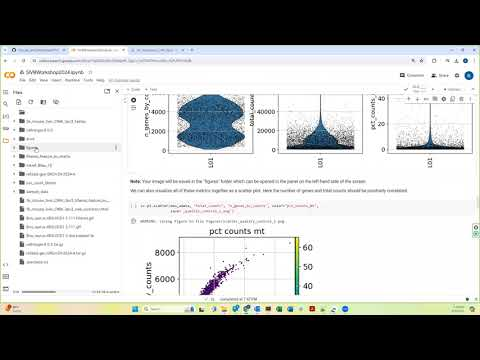

In [34]:
YouTubeVideo('2e8kzg5AoqI', width = 800, height = 400)

### __3.a. Setting up python environment__

We will need to ensure that all the necessary packages are available. Typically
you will want to do this in a virtual environment so that you can control and monitor package versions and prevent any conflicts. Here are the basics for how to set up that virtual environment.

<i>Note: This code cannot be executed in this Colab environment</i>
```{bash}
# Install virtualenv if not already installed
pip install virtualenv

# Go to your project folder
cd analysis_project

# Create virtual environment
# python<version> -m venv <virtual-environment-name>
python3.9 -m venv env

# Activate virtual environment
# Mac/Unix
source analysis_project/bin/activate
# Windows
analysis_project/activate
```

Google colab is a Python environment. However, not all packages for single-cell RNA sequencing analysis are installed. To install these we will use  `pip install` in the existing environment.

In [16]:
!pip install scanpy
!pip install scvi-tools
!pip install igraph
!pip install leidenalg

# We will copy the previously generated CellRanger outputsto our environment.
!cp ./drive/My\ Drive/SIVBWorkshop_Files/5k_mouse_liver_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz .
!tar -xzvf 5k_mouse_liver_CNIK_3pv3_filtered_feature_bc_matrix.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=b6abf623ed020ef1959ff07b6d9a624cbe7f61b59d71508beb91d5a0ea1eea8c
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 

Now we can import the new packages and set some default settings. Here we import the [scanpy single-cell](https://scanpy.readthedocs.io/en/stable/), [numpy](https://numpy.org/), [pandas data analysis and manipulation](https://pandas.pydata.org/), and [seaborn visualization](https://seaborn.pydata.org/) packages.

We will also set plotting defaults to 300dpi for in-screen and 600dpi when exported in a png or pdf format.

In [17]:
# Load packages for single-cell analysis and visualization
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# Set plotting settings
sc.set_figure_params(
    scanpy=True, dpi=150, dpi_save=600,
    frameon=True, vector_friendly=True,
    fontsize=14, figsize=None, color_map=None, format='png', facecolor=None,
    transparent=False, ipython_format='png'
  )

### <b>3.b. Defining sample names and path to outputs</b>

There are several ways to provide sample information to your analysis code so that it is tracked throughout the process. <b> You want to provide as comprehensive metadata as possible <i>(see FAIR data principles)</i></b>. Because we will only use 1 sample I prepare a table manually, but pandas can be used to import a table with metadata.

Here we will follow the [requirements from the Broad Single-Cell Portal](https://singlecell.zendesk.com/hc/en-us/articles/360060609852-Required-Metadata).

| Metadata Name                        | Content           | Description                                                                                     |
|--------------------------------------|-------------------|-------------------------------------------------------------------------------------------------|
| NAME                                 | string            | unique identifier for each cell in the study. Must be the first column in a metadata file        |
| biosample_id                         | string            | unique identifier for each sample in the study                                                  |
| donor_id                             | string            | unique identifier for each biosample donor in the study                                         |
| species                              | ontology          | ontology identifier from NCBItaxon                                                              |
| species__ontology_label              | ontology_label    | ontology label from NCBItaxon                                                                   |
| disease                              | ontology          | ontology identifier from MONDO or PATO (if no disease, use ontology ID "PATO_0000461")          |
| disease__ontology_label              | ontology_label    | ontology label from MONDO or PATO (if no disease, use ontology label "normal")                  |
| organ                                | ontology          | ontology identifier from Uberon                                                                 |
| organ__ontology_label                | ontology_label    | ontology label from Uberon                                                                      |
| library_preparation_protocol         | ontology          | ontology identifier from Experimental Factor ontology: library preparation                      |
| library_preparation_protocol__ontology_label | ontology_label    | ontology label from Experimental Factor ontology: library preparation                      |
| sex                                  | controlled list (enum) | one of ["male", "female", "mixed", "unknown"]                                                |



In [18]:
# Create a dictionary with the data
data = {
    'path': ['./filtered_feature_bc_matrix'], # The location of the CellRanger output on the computer
    'biosample_id': ['L01'],
    'donor_id': ['M001'],
    'species': ['NCBITaxon_10090'],
    'species__ontology_label': ['Mus musculus'],
    'disease': ['PATO_0000461'],
    'disease__ontology_label': ['Normal'],
    'organ': ['UBERON_0002107'],
    'organ__ontology_label': ['Liver'],
    'library_preparation_protocol': ['EFO_0009922'],
    'library_preparation_protocol__ontology_label': ["10x 3' v3"],
    'sex': ['Male'],
}

# Create the DataFrame
sample_details_df = pd.DataFrame(data)

# Display the table
display(sample_details_df)

,path,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex
0,./filtered_feature_bc_matrix,L01,M001,NCBITaxon_10090,Mus musculus,PATO_0000461,Normal,UBERON_0002107,Liver,EFO_0009922,10x 3' v3,Male


### <b>3.c. Data import and quality control</b>

The following code does the following for each row in the table we just created.

- Imports the data using `read_10x_mtx`.
- Builds the metadata from the table created above.
- Calculates QC metrics
- Saves the outputs in a <i>list</i>.

In [19]:
adata_list = []

for index, sample in sample_details_df.iterrows():
    print(sample['biosample_id'])

    # Imports the mtx formatted output from CellRanger
    adata = sc.read_10x_mtx(sample['path'])

    # Build metadata from sample_details table
    for column in sample_details_df.columns:
        if column != 'path':  # Skip the 'path' column
            adata.obs[column] = sample[column]

    # Calculate QC metrics
    adata.var["mt"] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=[20],
                               log1p=True, inplace=True)

    # Saves the output to a adata_list object
    adata_list.append(adata)

# Merge all the objects for subsequent processing (depends on experimental design!)
new_adata = sc.concat(adata_list, join='outer', index_unique=None, fill_value=0)


L01


#### <b> QC - basic metrics</b>

The most common preliminary QC metrics are the number of genes, transcripts, and mitochondrial RNA detected in each of your cells. These outputs can help identify unhealthy cells (high mitochondrial contamination), poor quality <i>cells</i> which have little/no RNA or putative doublets which have <i>too much</i> RNA.

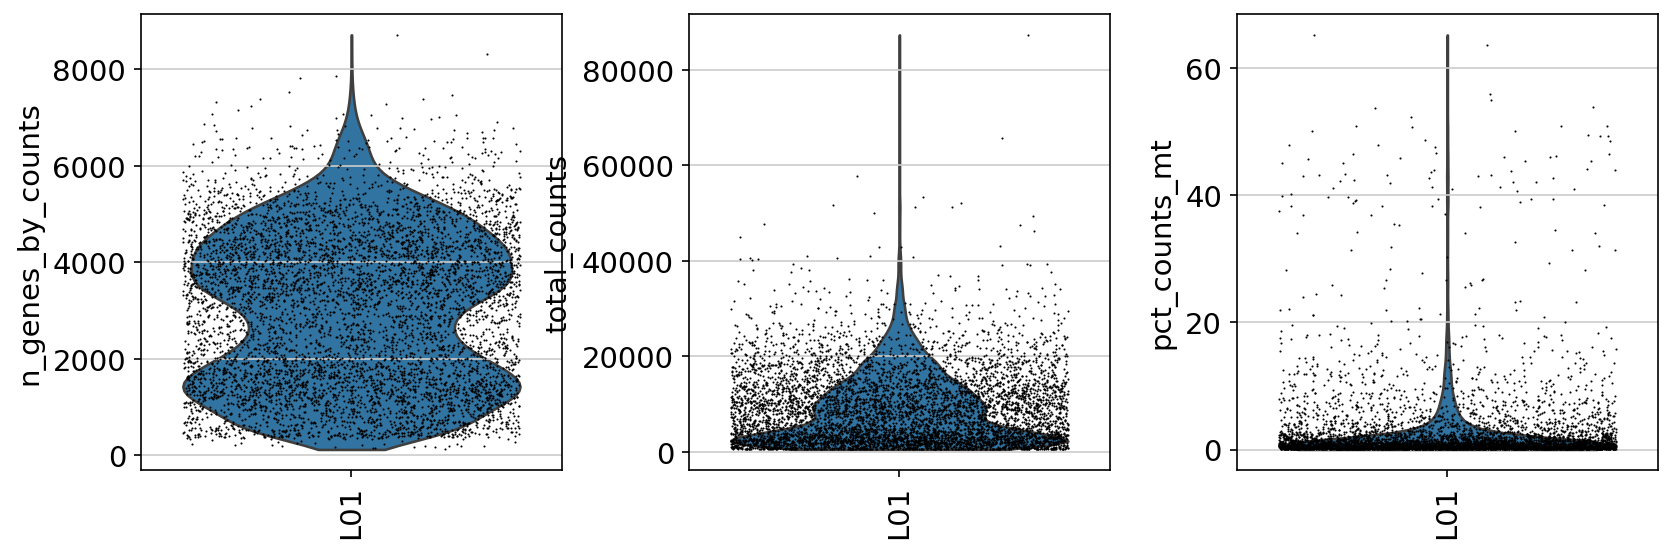

In [20]:
# Create violin plot
sc.pl.violin(new_adata,
             keys=['n_genes_by_counts', 'total_counts','pct_counts_mt'],
             jitter=0.4,
             groupby='biosample_id', rotation=90,
             save='_quality_control_1.png'
             )

<b>Note:</b> Your image will be saved in the "figures" folder which can be opened in the panel on the left hand side of the screen.

We can also visualize all of these metrics together as a scatter plot. Here the number of genes and total counts should be positively correlated.

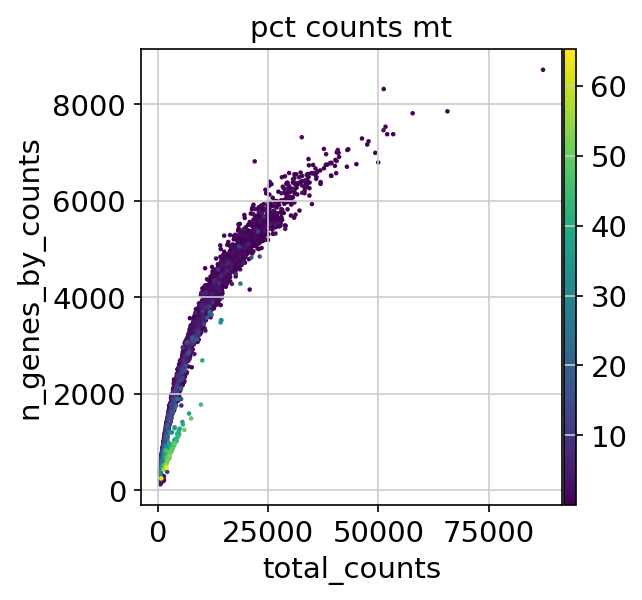

In [21]:
sc.pl.scatter(new_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",
              save='_quality_control_1.png')

### <b>3.d. Doublets and ambient RNA cleanup</b>

> <b>Note:</b> We will not run this step as part of this tutorial as these tasks are more involved and often require the use of different packages in Python and R.

Doublets and ambient RNA can sometimes pose significant analysis and interpretation challenges downstream if not accounted for properly. The extent to which these factors affect your data will largely depend on the wet lab steps of single-cell RNA sequencing. For example, nuclei isolation can often lead to elevated ambient RNA resulting from the release of cytosolic RNA. Similarly, overloading cells can increase the doublet rate leading to cells with artificially high counts. <b> Protocol optimization is crucial to minimize the impact of these issues.</b>

To run some of these cleanup steps you can explore the following popular tools (<i>not a comprehensive list</i>) and their associated tutorials:
- [SoupX](https://academic.oup.com/gigascience/article/9/12/giaa151/6049831?login=false) - ambient RNA removal
- [scDblFinder](https://doi.org/10.12688%2Ff1000research.73600.2) - Doublet detection
- [Scrublet](https://www.sciencedirect.com/science/article/pii/S2405471218304745) - Doublet detection

### <b>3.e. Filter based on QC metrics</b>

Finally, after we've performed all the quality control, we want to remove poor quality cells, doublets, or those that appear to not be cells at all. Many of these values will be driven by the biology and your expertise with the tissue, as well as examining the output for clear outliers.

Here we filter cells with fewer than 100 genes and genes detected in fewer than 3 cells.

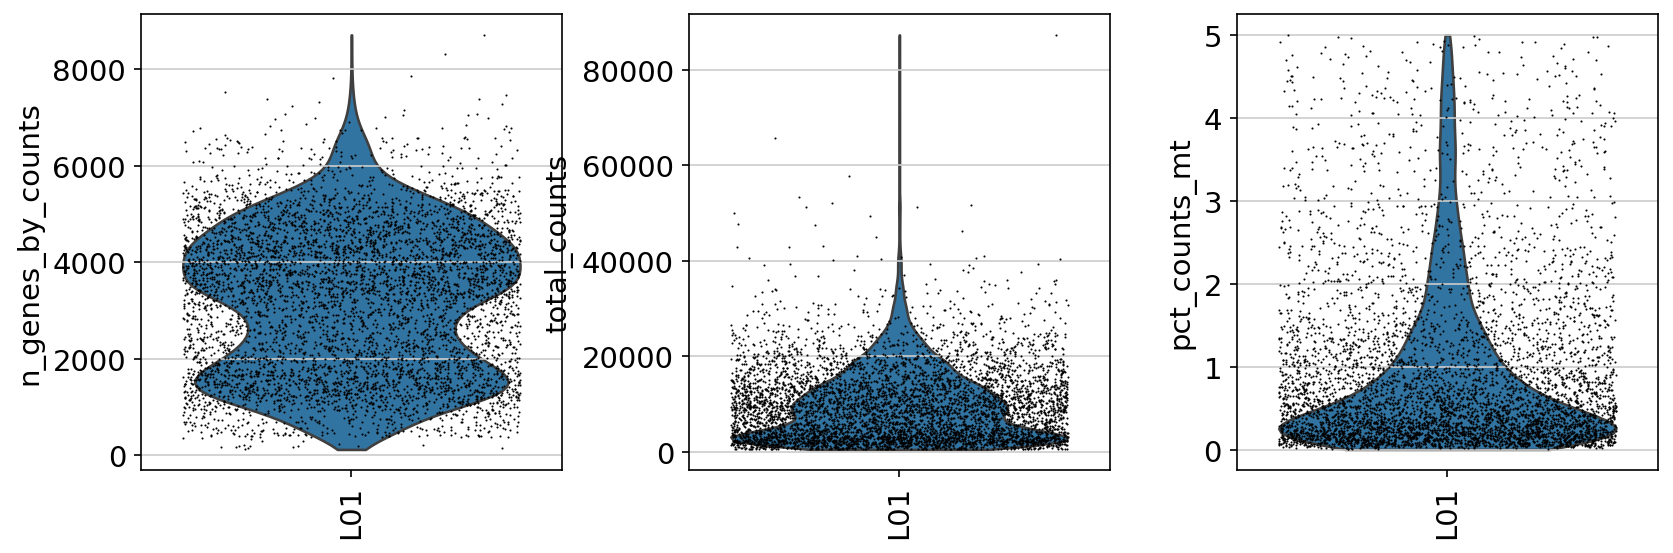

In [22]:
sc.pp.filter_cells(new_adata, min_genes=100)
sc.pp.filter_genes(new_adata, min_cells=3)

# filter for percent mito
new_adata = new_adata[new_adata.obs['pct_counts_mt'] < 5, :]

# Rerun the violin QC plots
sc.pl.violin(new_adata,
             keys=['n_genes_by_counts', 'total_counts','pct_counts_mt'],
             jitter=0.4,
             groupby='biosample_id', rotation=90,
             save='quality_control_filtered.png'
             )

At this step we may also decide to apply additional filtering criteria such as removal of doublets. These decisions will have to be driven by the biology and expertise with the study model.  

### __3.f. Normalisation and dimensionality reduction__

Once we have performed our quality control and removed our poor quality cells, it is time to start analyzing the data for the identification of cell populations and their expression patterns.

#### <b>Normalisation</b>
We start by normalizing the data so that any effect of variable read depth is eliminated and we transform the data into log space so that it is easier to work with and visualize.  

In [23]:
# Saving count data in case we need it later
new_adata.layers["counts"] = new_adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(new_adata)

# Logarithmize the data
sc.pp.log1p(new_adata)

<ipython-input-23-cee9ea9d781a>:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  new_adata.layers["counts"] = new_adata.X.copy()


#### <b>Feature Selection</b>

Not all genes will be helpful in resolving cell differences. To use the genes which are most likely to differentiate cell types we use only the 2000 most variable genes.

In [24]:
# Identify most variable genes
sc.pp.highly_variable_genes(new_adata, n_top_genes=2000, batch_key="biosample_id")

#### <b>Dimensionality reduction</b>

We have data for thousands of genes and cells making it very hard to analyze and visualize. To make this data more manageable, we use dimension reduction techniques. These techniques reduce the number of variables under consideration, while preserving as much important information as possible. We use two popular methods for dimension reduction:  <i>principal Components Analysis (PCA)</i> and <i>Uniform Manifold Approximation and Projection (UMAP)</i>.

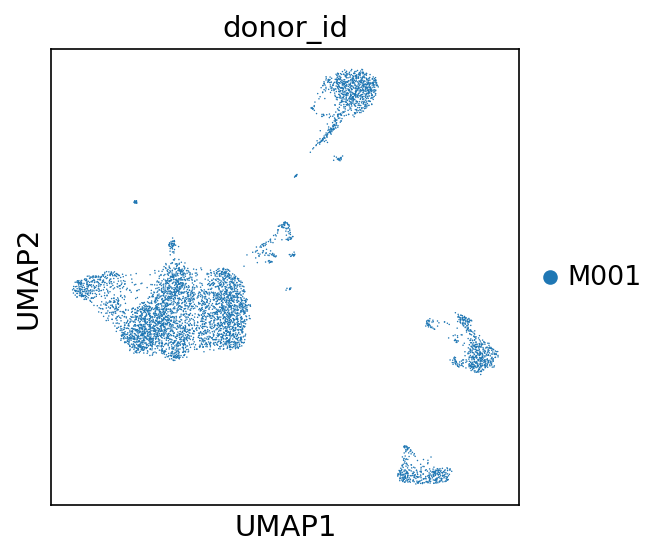

In [25]:
# Perform PCA (Principal Component Analysis).
sc.tl.pca(new_adata)

# Compute the PCA neighborhood graph of the data to be used for UMAP.
sc.pp.neighbors(new_adata)

# Perform UMAP (Uniform Manifold Approximation and Projection).
sc.tl.umap(new_adata)

# Plot the UMAP results.
# The plot colors data points based on the "donor_id" variable to differentiate between donors.
# The `size=2` parameter sets a smaller point size to reduce overlap in the plot.
# The `save='_unclustered.png'` parameter saves the plot to a file named 'umap_unclustered.png'.
sc.pl.umap(
    new_adata,
    color="donor_id",
    size=2,
    save='_unclustered.png'
)

#### <b>Clustering</b>

The ultimate goal of single-cell RNA sequencing experiments is to derive cell-specific expression information. To achieve this, we need to first define the distinct cell types within the dataset. We accomplish this by performing <i>Leiden clustering</i>, which is a community detection algorithm used to identify clusters of cells with similar gene expression profiles.

<ipython-input-26-95c5a0b48952>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(new_adata,  resolution=0.1, n_iterations=2)


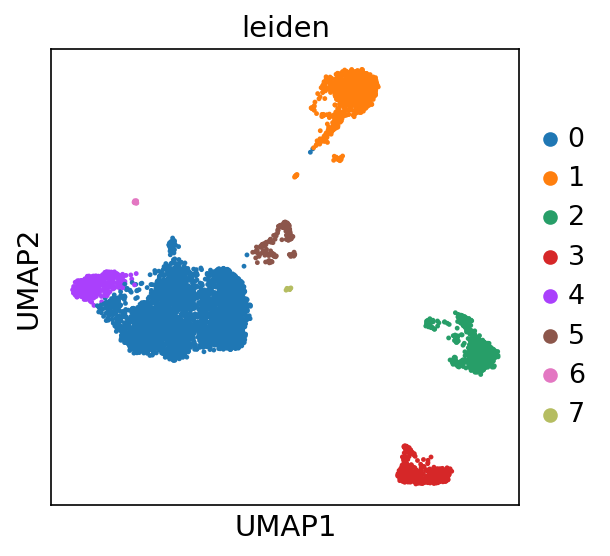

In [26]:
# Perform Leiden clustering on the data with 2 iterations and a resolution of 0.5.
sc.tl.leiden(new_adata,  resolution=0.1, n_iterations=2)

# Plot the UMAP results with the adjusted resolution clusters.
# The plot colors data points based on the new clusters identified with the reduced resolution.
# Saves the plot to a file named 'umap_clustered.png'.
sc.pl.umap(new_adata,
           color=["leiden"],
           save='_clustered.png'
           )

#### <b>Examine the data</b>

There are several ways to explore the data in order to be able to start identifying what each cell type the clusters represent.

Let's start with finding the top 3 genes that are enriched in each of the clusters.

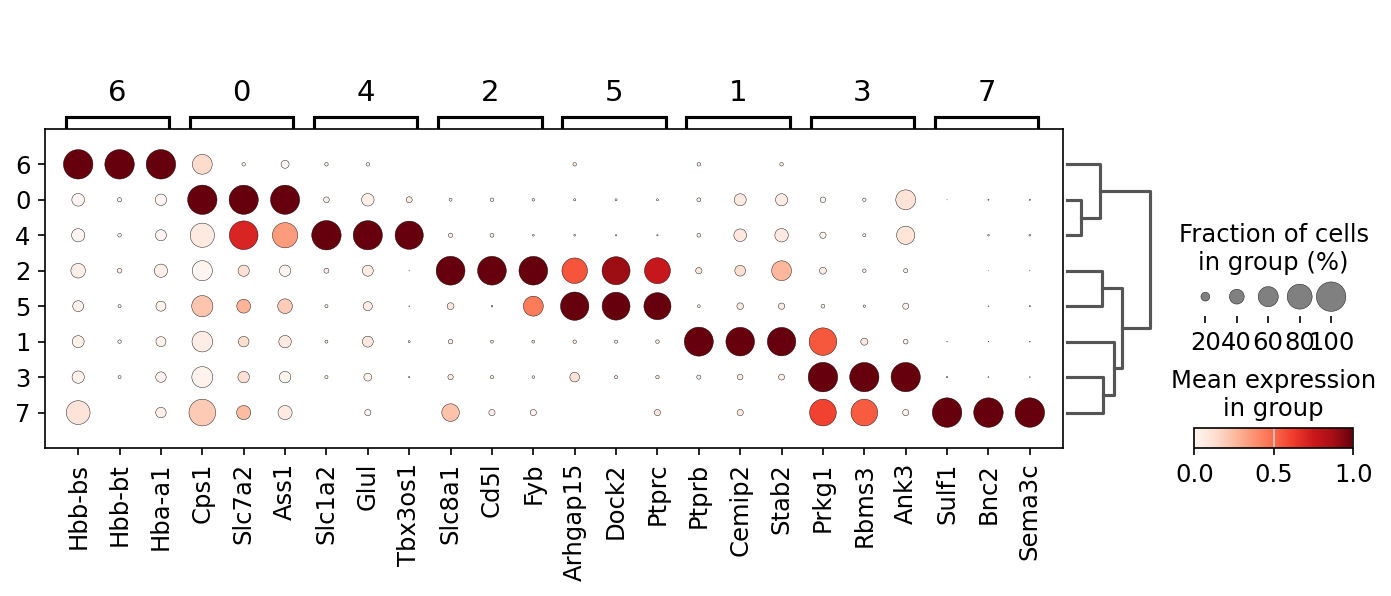

In [27]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(new_adata, groupby="leiden", method="wilcoxon")

# Plot the top 3 genes for each cluster
sc.pl.rank_genes_groups_dotplot(
    new_adata,
    groupby="leiden",
    standard_scale="var",
    n_genes=3,
    save='_cluster_markers.png'
)

We can also look at where some of these genes are expressed. For example, let's see where the markers for pericentral hepatocytes (<i>Ass1</i>), central hepatocytes (<i>Glul</i>), macrophage (<i>Slc8a1</i>), and sinusoidal endothelial cells (<i>Stab2</i>) are expressed.

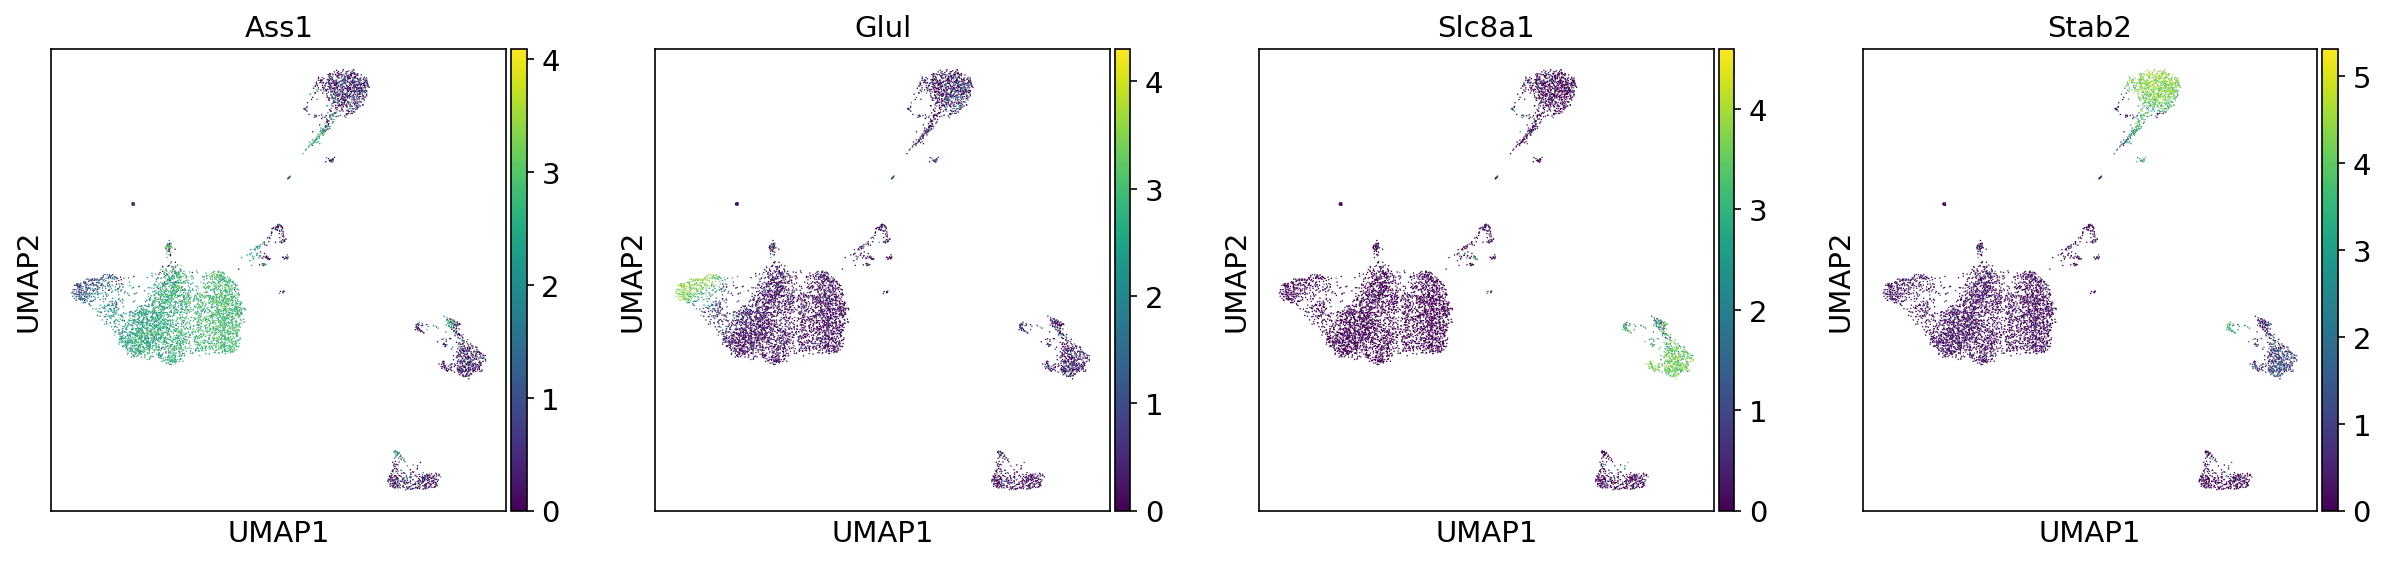

In [28]:
sc.pl.umap(
    new_adata,
    color=['Ass1', 'Glul', 'Slc8a1', 'Stab2'],
    # Setting a smaller point size to get prevent overlap
    size=2,
    save='_celltype_markers.png'
)

These UMAP plots show the clear cluster-specific expression which can be used to annotate them based on the marker genes. <b> Identification of these markers and annotation will be driven by biological expertise</b>, though new and emerging machine learning and artificial intelligence approaches are being developed to help researchers with this task.

-----------------------------
## <b>4. Summary</b>

In [35]:
YouTubeVideo('_rL83xRbUhc', width = 800, height = 400)

This walkthrough of single-cell RNA sequencing data analysis is intended to give you a broad overview on working with these type of data. <b>Remember that each technology may have small differences and analysis tools are continuously evolving.</b> It is a good idea to check the documentation of your analysis packages before you start to find out about any updates.

<b>The following are useful resources to check out:</b>

- [Single-cell best practices](https://www.sc-best-practices.org/preamble.html)
- [Scanpy](https://scanpy.readthedocs.io/)
- [Seurat](https://satijalab.org/seurat/)